In [1]:
import sys

sys.path.append("../src")

# Quickstart 2: Functional Autoencoder (FAE)

This notebook gives a simple introduction to get started with the **functional autoencoder** (FAE), loosely based on the Navier–Stokes example in section 4.3.1 of [the paper](https://arxiv.org/abs/2408.01362).

> ⚠ **Have you installed the dependencies for `functional_autoencoders` yet?** If not, head to the `functional_autoencoders/` directory in your terminal and run `pip install -r requirements.txt`. 

> ℹ️ **If you've already read the [Introduction to FVAE](./1_FVAE.ipynb) notebook**, you might already be familiar with some of the concepts in this notebook. They're repeated here so you can read this notebook without having read the Introduction to FVAE notebook.

**Dataset**. The dataset consists of 4,000 training and 1,000 evaluation samples of solution snapshots at $T = 50$ to the 2D Navier–Stokes equations with periodic boundary and Gaussian initial conditions, all provided at resolution $64 \times 64$.

The dataset is ~3 GB large and will automatically download on the first run of this notebook before being cached locally. This may take some time. 

In [2]:
from functional_autoencoders.datasets.navier_stokes import NavierStokes
from functional_autoencoders.datasets import get_dataloaders

train_dataloader, test_dataloader = get_dataloaders(
    NavierStokes, resolution=64, viscosity=1e-3
)



The `get_dataloaders` helper function can take any dataset from `functional_autoencoders.datasets` and instantiate dataloaders (based on the PyTorch dataloader, as explained in [the JAX documentation](https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html)) for the training and test datasets.


### How should functions be represented in `functional_autoencoders`?

**Functions as point clouds.**
We represent a discretised function $u \colon \Omega \subset \mathbb{R}^{d} \to \mathbb{R}^{m}$ as a **point cloud**: mathematically, a sequence 

$$ \Bigl\{ \bigl(x_{i}, u(x_{i})\bigr) \Bigr\}_{i = 1}^{N} \subset \Omega \times \mathbb{R}^{m}. $$



In other words, we represent discretised functions by evaluating them at $N$ points in the domain $\Omega$.
In code, we represent the point cloud $\{(x_{i}, u(x_{i}))\}$ using a pair of JAX arrays `(u, x)`, where:

- `x` is a JAX array of shape `(N, d)`, with `x[i,:]` representing the $d$-dimensional vector $x_{i}$; and
- `u` is a JAX array of shape `(N, m)`, with `u[i,:]` representing the $m$-dimensional vector $u(x_{i})$.

To illustrate the idea, consider a function $u \colon [0, 1]^{2} \to \mathbb{R}$, which could represent, for example, a greyscale image with a single output channel.
Suppose that, instead of being pixellated on a grid, we're given the value of the function at 7 locations, $\{x_{1}, \dots, x_{7}\}$.
Then, in the notation above, $d = 2$ and $m = 1$, and we represent the *point cloud* as a pair of JAX arrays `(u,x)` as shown below:

![Illustration of point-cloud representation of data](./images/point-cloud_representation.png)

**Encoding and decoding on arbitrary meshes.**
Remember that, thanks to the mesh invariance of the encoder, we can encode any point cloud `(u, x)`.
We'll call the point cloud that is given to the encoder `(u_enc, x_enc)`, where `u_enc` has shape `[N, m]` and `x_enc` has shape `[N, d]`. 
After encoding, we get a single array `z` of shape `[d_z]`, representing the latent vector $z \in \mathbb{R}^{d_{\mathcal{Z}}}$.

The decoder is also mesh invariant, so we can ask it to map from the latent vector `z` to another point cloud `(u_dec, x_dec)` on the specified mesh `x_dec`. 
**Crucially, `x_dec` doesn't have to be the same as `x_enc`: it could be a completely different array of points of shape `[M, d]`.**
After giving the decoder both `z` and `x_dec`, we obtain the array `u_dec` of shape `[M, m]`, as illustrated below:

![Encoding and decoding on different meshes](./images/enc_dec.png)


### What is the format used by the data loaders in `functional_autoencoders`?

When training FVAE or FAE, we need two point clouds:
- the input point cloud `(u_enc, x_enc)`, which will be given to the encoder; and
- the point cloud `(u_dec, x_dec)`, to which we'll compare the output of the autoencoder.

All of our data sets in `functional_autoencoders.datasets` therefore return tuples `(u_enc, x_enc, u_dec, x_dec)`.
By default, `x_enc = x_dec` and `u_enc = u_dec`, so we encode the function discretised on the full mesh, decode back to the same mesh, and compare the output of the decoder with the true values of the function $u$. 
However, the reason for this convention is that it's often useful for `(u_enc, x_enc)` and `(u_dec, x_dec)` to be different point-cloud discretations of the same function $u$.
We'll see this in more detail in the next notebook when discussing **self-supervised training**.

It might be helpful to think of autoencoding as a **regression task** where the input and output is always the same: so we're trying to predict the target point cloud `(u_dec, x_dec)` from the input point cloud `(u_enc, x_enc)`, and it's always the case that the two point clouds represent the same function.

> ⚠️ In practice, we'll use the `train_dataloader` and `test_dataloader` objects as iterators, which batch the point clouds. For computational reasons, the **size** of the mesh (`N` and `M`) has to be constant per batch, and the arrays will thus have shape:
> - `u_enc`: `[batch, N, m]`
> - `x_enc`: `[batch, N, d]`
> - `u_dec`: `[batch, M, m]`
> - `x_dec`: `[batch, M, d]`. 
>
> In particular, this means that in each batch, the **locations** of the mesh points might be different for each sample, but the number of mesh points is constant within the batch. The number of mesh points can, however, vary between batches.


For the purpose of visualization, let's access a single element from the underlying dataset.

Text(0.5, 1.0, 'u_dec')

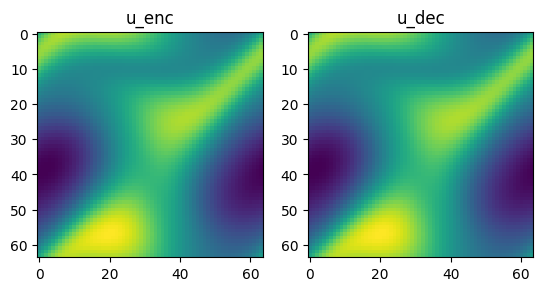

In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt


u_enc, x_enc, u_dec, x_dec = next(iter(train_dataloader))
# We'll take advantage of the fact that, although `u_enc` is a 2D array of shape [batch, number_of_evaluations],
# for this specific dataset the order of the evaluations is such that `u_enc_mat` is in the correct order!
u_enc_mat = jnp.reshape(u_enc[0], (64, 64))
u_dec_mat = jnp.reshape(u_dec[0], (64, 64))
plt.subplot(1, 2, 1)
plt.imshow(u_enc_mat)
plt.title("u_enc")
plt.subplot(1, 2, 2)
plt.imshow(u_dec_mat)
plt.title("u_dec")

**Self-supervised training**. One of the key benefits of FAE is the ability to randomly mask inputs to the encoder and decode only on the masked parts of the image, which greatly improves robustness to mesh changes.

![FAE self-supervised training](./images/FAE_self-supervised_training.png)

Using self-supervised training is easy with `functional_autoencoders`; we'll use `ComplementMasking` which generates a new random mask to apply to `u_enc` and `x_enc` in each batch, and applies the *complement* of the mask to `u_dec` and `x_dec`.
Choosing an `encoder_point_ratio` of 0.3 means that 30% of points in `u_enc` will be kept and 70% will be masked; thus 30% will be masked and 70% kept in `u_dec`. We won't apply any masking to the evaluation data–only the training data!

In [4]:
from functional_autoencoders.datasets import ComplementMasking

mask_train = ComplementMasking(encoder_point_ratio=0.3)
train_dataloader, test_dataloader = get_dataloaders(
    NavierStokes, resolution=64, viscosity=1e-3, transform_train=mask_train
)

Now, let's learn how to set up the FAE architecture and training objective. There is a wide selection of encoders and decoders to choose from (see [the custom architectures notebook](./4_Custom_Architectures.ipynb) for more on this), but we'll stick with the architectures described in the paper:

**`PoolingEncoder`**, which at the function-space level is given by integration of a learnable vector-valued kernel $\kappa$ followed by a learnable MLP $\rho$, i.e.,

$$\rho\left( \int_{\Omega} \kappa\bigl(x, u(x)\bigr) \,\mathrm{d} x \right),$$

and closely resembles architectures such as Deep Sets and PointNets.

![FVAE `PoolingEncoder`](./images/FVAE_encoder.png)



**NonlinearDecoder**, which is a coordinate MLP taking the latent vector $z$ and a query point $x_{k}$ and returning the value $u(x_{k})$ of the decoded function.

![FVAE `NonlinearDecoder`](./images/FVAE_decoder.png)

The most important things to choose for the encoder and decoder architectures are:

1. Whether we're training a variational autoencoder (`is_variational = True`) or not (`is_variational = False`), which determines whether the encoder outputs distributional parameters for a Gaussian variational approximation (FVAE) or just a single point (FAE).
2. The dimension `latent_dim` of the latent space $\mathcal{Z} = \mathbb{R}^{d_{\mathcal{Z}}}$ (for FVAE, this is the dimension of the encoder mean).
3. The parameter `out_dim`, which controls the dimension of the **range** of the decoded functions.

We'll also use random Fourier features in both the encoder and decoder, which significantly improve expressivity.
Once the encoder and decoder are set up, they can be combined to form the `Autoencoder` object.

In [5]:
from functional_autoencoders.autoencoder import Autoencoder
from functional_autoencoders.decoders.nonlinear_decoder import NonlinearDecoder
from functional_autoencoders.encoders.pooling_encoder import PoolingEncoder
from functional_autoencoders.positional_encodings import RandomFourierEncoding
import jax

key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
B = jax.random.normal(subkey, (32, 2))

positional_encoding = RandomFourierEncoding(B)
encoder = PoolingEncoder(
    is_variational=False, latent_dim=64, positional_encoding=positional_encoding
)
decoder = NonlinearDecoder(out_dim=1, positional_encoding=positional_encoding)
autoencoder = Autoencoder(encoder, decoder)

Once the architecture is fixed, we now need to set up a loss function. We'll use the FAE loss function in `functional_autoencoders.losses.fae`, because for this dataset there is no obvious choice of Gaussian noising distribution to allow the FVAE methodology to be applied. 


All losses in `functional_autoencoders` require that you pass a `domain` object, which encodes the underlying function space that the data lie in and the appropriate function-space norms. 
For the `fae` loss, we provide domain objects for:
  - functional data defined on a square domain $[0, 1]^{d}$ with zero boundary conditions, discretised on a grid (`functional_autoencoders.domains.grid.ZeroBoundaryConditions`)
  - functional data defined on a periodic domain $\mathbb{T}^{d}$, discretised on a grid (`functional_autoencoders.domains.grid.PeriodicBoundaryConditions`)
  - functional data on a square domain (with arbitrary boundary conditions), discretised on possibly non-grid meshes (`functional_autoencoders.domains.off_grid.RandomlySampledEuclidean`).

The `grid` domains allow for the assumption that the data lies in a Sobolev space of nonzero order, and the commensurate use
of Sobolev norms in the loss, whereas the `non_grid` do not permit this. 
In this notebook, we'll go with `RandomlySampledEuclidean` because we want to use random masking, meaning that the data may well not lie on a grid.

Once the `domain` object is set up, we just need to obtain a loss function by passing:
- the `autoencoder` architecture we just set up;
- the `domain` object;
- the hyperparameter `beta`, which controls the scale of the regularisation on the latent space.

In [6]:
from functional_autoencoders.domains.off_grid import RandomlySampledEuclidean
from functional_autoencoders.losses.fae import get_loss_fae_fn

BETA = 1e-5

domain = RandomlySampledEuclidean(s=0.0)
loss_fn = get_loss_fae_fn(autoencoder, domain, BETA)

Now we have a resolution-invariant architecture and loss, we can get started with the training process. 
Since our architecture is built on top of [JAX](https://github.com/google/jax) and [Flax](https://flax.readthedocs.io/en/latest/), you can write your own training loop easily if you like, but we provide a simple trainer, `AutoencoderTrainer`, suitable for quick prototyping.

The `AutoencoderTrainer` requires the `autoencoder` and `loss_fn` objects we just set up, as well as the `train_dataloader` and `test_dataloader`. 
It supports computing validation metrics (e.g., mean-square error) on the `test_dataloader` by specifying a list of `metrics`. 

To run the trainer, just call the `fit` method and specify the training hyperparameters such as learning rate (`lr`). 
Since we're using JAX, you need to explicitly pass a pseudorandom number generator key; you can read more about this in the [JAX documentation](https://jax.readthedocs.io/en/latest/random-numbers.html).

Training FAE will take some time and will be very slow without a dedicated GPU.

In [7]:
import jax

from functional_autoencoders.train.autoencoder_trainer import AutoencoderTrainer
from functional_autoencoders.train.metrics import MSEMetric

trainer = AutoencoderTrainer(
    autoencoder=autoencoder,
    loss_fn=loss_fn,
    metrics=[MSEMetric(autoencoder=autoencoder, domain=domain)],
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
)
key, subkey = jax.random.split(key)
results = trainer.fit(
    subkey,
    lr=1e-3,
    lr_decay_step=1_000,
    lr_decay_factor=0.9,
    max_step=50_000,
    verbose="metrics",
)

Parameter count: 82881
epoch      0 || MSE (in L^{2}): 2.235E-02
epoch     10 || MSE (in L^{2}): 7.718E-03
epoch     20 || MSE (in L^{2}): 2.073E-03
epoch     30 || MSE (in L^{2}): 9.105E-04
epoch     40 || MSE (in L^{2}): 5.768E-04
epoch     50 || MSE (in L^{2}): 4.382E-04
epoch     60 || MSE (in L^{2}): 3.500E-04
epoch     70 || MSE (in L^{2}): 2.726E-04
epoch     80 || MSE (in L^{2}): 2.534E-04
epoch     90 || MSE (in L^{2}): 2.172E-04
epoch    100 || MSE (in L^{2}): 1.910E-04
epoch    110 || MSE (in L^{2}): 1.647E-04
epoch    120 || MSE (in L^{2}): 1.611E-04
epoch    130 || MSE (in L^{2}): 1.515E-04
epoch    140 || MSE (in L^{2}): 1.485E-04
epoch    150 || MSE (in L^{2}): 1.411E-04
epoch    160 || MSE (in L^{2}): 1.256E-04
epoch    170 || MSE (in L^{2}): 1.166E-04
epoch    180 || MSE (in L^{2}): 1.225E-04
epoch    190 || MSE (in L^{2}): 1.131E-04
epoch    200 || MSE (in L^{2}): 1.099E-04
epoch    210 || MSE (in L^{2}): 1.063E-04
epoch    220 || MSE (in L^{2}): 1.059E-04
epoch    23

### Masking Options for Encoder Input

When applying masking to the encoder input, you can choose from one of the following three options:

1. **GRF (Gaussian Random Field) Masking**:
2. **Rectangular Masking**:
3. **Uniform Masking**:

Feel free to try any of these options and perhaps even a custom implementation.

In [8]:
from functional_autoencoders.util.masks import (
    get_mask_grf_torus,
    get_mask_rect,
    get_mask_uniform,
)

# get_mask_fn = lambda key, u: get_mask_grf_torus(key, u, threshold=-0.05, tau=30, d=1.2)
# get_mask_fn = lambda key, u: get_mask_rect(key, u, h=30, w=30)
get_mask_fn = lambda key, u: get_mask_uniform(key, u, mask_ratio=0.95)

An index for a specific image from a test dataloader batch is used to specify the data we wish to mask.

In [9]:
IDX = 0
u_batch, x_batch, _, _ = next(iter(test_dataloader))
u_orig = u_batch[IDX][None, :]
x_orig = x_batch[IDX][None, :]

The mask is applied to the data.

In [10]:
key, subkey = jax.random.split(key)
mask = get_mask_fn(subkey, u_orig)

u_mask_partial = u_orig[:, ~mask, :]
x_mask_partial = x_orig[:, ~mask, :]

u_mask = u_orig.copy()
u_mask[:, mask] = 0

We may then pass the applied masked data to the autoencoder to obtain the reconstructed data and display the results.

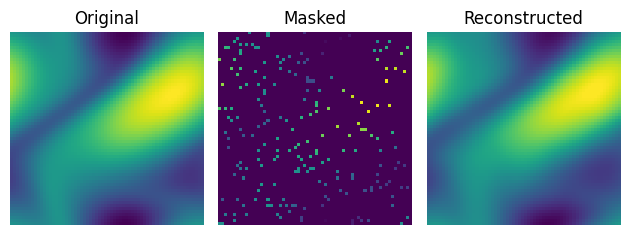

In [11]:
state = results["state"]
vars = {"params": state.params, "batch_stats": state.batch_stats}
u_rec = autoencoder.apply(vars, u_mask_partial, x_mask_partial, x_orig)

n = int(u_orig.shape[1] ** 0.5)
u_orig = u_orig.reshape(n, n)
u_rec = u_rec.reshape(n, n)
u_mask = u_mask.reshape(n, n)

cmap = "viridis"
vmin = jnp.min(u_orig)
vmax = jnp.max(u_orig)

plt.subplot(1, 3, 1)
plt.imshow(u_orig, cmap=cmap, vmin=vmin, vmax=vmax)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(u_mask, cmap=cmap, vmin=vmin, vmax=vmax)
plt.title("Masked")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(u_rec, cmap=cmap, vmin=vmin, vmax=vmax)
plt.title("Reconstructed")
plt.axis("off")

plt.tight_layout()
plt.show()

Unlike FVAE, we can't generate new samples directly by drawing $z \sim N(0, I_{d_{\mathcal{Z}}})$ and pushing through the decoder:
FAE isn't a probabilistic model and, although we're regularising the latent space, there's no reason that sampling in this way would give sensible outputs.

However, since the latent space is regularised, we could expect that training a generative model *on the latent space* to match the distribution of encoded inputs from the training dataset would be a sensible idea. 
As in [the paper](https://arxiv.org/abs/2408.01362), we'll train a Gaussian mixture model using the **full** (unmasked) training data using `SamplerGMM`. 

In [ ]:
import math
from functional_autoencoders.util import get_raw_x
from functional_autoencoders.samplers.sampler_gmm import SamplerGMM

train_dataloader_full, _ = get_dataloaders(NavierStokes, resolution=64, viscosity=1e-3)

sampler = SamplerGMM(autoencoder, results["state"], n_components=10)
sampler.fit(train_dataloader_full)

Once the Gaussian Mixture Model (GMM) sampler is fitted, we can sample from it. 

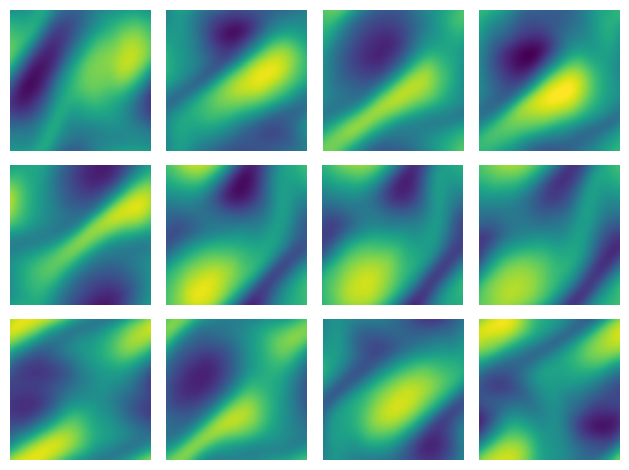

In [13]:
PTS = 64
N_SAMPLES = 12
SUBPLOTS_PER_ROW = 4

x = get_raw_x(PTS, PTS)
x_tile = jnp.tile(jnp.expand_dims(x, 0), (N_SAMPLES, 1, 1))
samples = sampler.sample(x_tile)

n = int(math.sqrt(samples.shape[1]))
subplot_height = math.ceil(samples.shape[0] / SUBPLOTS_PER_ROW)
for i in range(samples.shape[0]):
    u = samples[i]
    plt.subplot(subplot_height, SUBPLOTS_PER_ROW, i + 1)
    plt.imshow(u.reshape(n, n), cmap="viridis", vmin=0, vmax=1)
    plt.axis("off")

plt.tight_layout()
plt.show()

## What next?
- If you haven't already, learn about the **functional variational autoencoder** (FVAE) in [`quickstart/1_FVAE.ipynb`](./1_FVAE.ipynb).
- Learn how to use FVAE and FAE with your own data in [`quickstart/3_Custom_Datasets.ipynb`](./3_Custom_Datasets.ipynb).